# Training a RL Agent in BipedalWalker-v3
__Author__ : Mohammad Rouintan , 400222042

__Course__ : Undergraduate Artificial Neural Networks Course

In [1]:
!pip -q install gymnasium

In [2]:
!apt-get update && apt-get install -y swig
!pip -q install gymnasium[box2d]

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]   
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1617 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]       
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:9 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1454 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3017 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [3626 kB]
Hit:12 http://archive.ubuntu.com/ubuntu focal-backports I

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch import optim
from torch.nn import functional as F
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import tqdm

import warnings
warnings.filterwarnings('ignore')

import pickle as p

from copy import deepcopy
from gymnasium.core import Env

import csv
import gymnasium as gym
from os import path
from time import time

In [4]:
for lib in [np, pd, sns, sklearn, torch, tqdm, torchvision, cv, PIL]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.2
seaborn --> 0.12.2
sklearn --> 1.2.2
torch --> 2.1.2
tqdm --> 4.66.4
torchvision --> 0.16.2
cv2 --> 4.10.0
PIL --> 9.5.0


In [5]:
class Model(nn.Module):
    def __init__(self, neurons, final_act, lr, device):
        super().__init__()
        self.neurons = neurons
        self.final_act = final_act
        self.model = self._init_layers()
        self.lr = lr
        self.device = device
        self.to(self.device)

        self._init_optimizer()

    def _init_layers(self):
        layers = []
        for i in range(1, len(self.neurons)):
            in_feats = self.neurons[i - 1]
            out_feats = self.neurons[i]
            layers.append(nn.Linear(in_feats, out_feats))
            if i < len(self.neurons) - 1:
                layers.append(nn.ReLU())
        layers.append(self.final_act())
        return nn.Sequential(*layers)


    def _init_optimizer(self):
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

In [6]:
class Memory:
    def __init__(self, observation_dim, action_dim, device, size=1_000_000):
        self.device = device
        self.cursor = 0
        self.curr_size = 0
        self.size = size

        self.states = torch.zeros((size, observation_dim), device=self.device)
        self.actions = torch.zeros((size, action_dim), device=self.device)
        self.rewards = torch.zeros(size, device=self.device)
        self.nextStates = torch.zeros((size, observation_dim), device=self.device)
        self.doneFlags = torch.zeros(size, device=self.device)

    def learn(self, state, action, reward, nextState, doneFlag):
        ptr = self.cursor

        state_tensor = torch.tensor(state, device=self.device)
        action_tensor = torch.tensor(action, device=self.device)
        nextstate_tensor = torch.tensor(nextState, device=self.device)

        self.states[ptr, :] = state_tensor
        self.actions[ptr, :] = action_tensor
        self.rewards[ptr] = reward
        self.nextStates[ptr, :] = nextstate_tensor
        self.doneFlags[ptr] = float(doneFlag)

        self.cursor = (self.cursor + 1) % self.size
        self.curr_size = min(self.curr_size + 1, self.size)

    def get_batch(self, size):
        size = min(size, self.curr_size)
        indices = torch.randint(0, self.curr_size, (size,), device=self.device)

        batch = {
            'states': self.states[indices, :],
            'actions': self.actions[indices, :],
            'rewards': self.rewards[indices],
            'nextStates': self.nextStates[indices, :],
            'doneFlags': self.doneFlags[indices],
        }
        return batch

In [7]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [8]:
class Agent:
    def __init__(self, env, lr, gamma, tau):
        self.observation_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        self.folder = '/kaggle/working/RL-Assign/'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.should_load = True

        if not os.path.isdir(self.folder):
            os.mkdir(self.folder)
        self.env_name = os.path.join(self.folder, env.name + '.')
        self.load_models()

    def get_noisy_act(self, state, sigma):
        deterministic_act = self.get_act(state)
        noise = np.random.normal(0, sigma, deterministic_act.shape)
        return np.clip(deterministic_act + noise, -1, +1)

    def get_act(self, state):
        actions = self.actor.forward(torch.tensor(state, device=self.device))
        return actions.cpu().detach().numpy()

    def q_loss(self, network, states, actions, targets):
        QValues = torch.squeeze(network.forward(torch.hstack([states, actions]).float()))
        return torch.square(QValues - targets).mean()

    def policy_loss(self, states):
        actions = self.actor.forward(states.float())
        QValues = torch.squeeze(self.critic1.forward(torch.hstack([states, actions]).float()))
        return -QValues.mean()

    def find_targets(self, rewards, nextStates, dones, tr_sigma, tr_clip):
        target_acts = self.final_actor.forward(nextStates.float())

        noise = torch.normal(0, tr_sigma, target_acts.shape, device=self.device)
        clipped_noise = torch.clip(noise, -tr_clip, +tr_clip)
        target_acts = torch.clip(target_acts + clipped_noise, -1, +1)

        target_q1_vals = torch.squeeze(self.final_critic1.forward(torch.hstack([nextStates, target_acts]).float()))
        target_q2_vals = torch.squeeze(self.final_critic2.forward(torch.hstack([nextStates, target_acts]).float()))
        target_q_vals = torch.minimum(target_q1_vals, target_q2_vals)

        return rewards + self.gamma * (1 - dones) * target_q_vals

    def update(self, batch_size, tr_sigma, tr_clip, update_policy):
        batch_data = self.memory.get_batch(batch_size)

        states = batch_data['states']
        actions = batch_data['actions']
        rewards = batch_data['rewards']
        nextStates = batch_data['nextStates']
        dones = batch_data['doneFlags']

        targets = self.find_targets(rewards, nextStates, dones, tr_sigma, tr_clip)

        Q1Loss = self.q_loss(self.critic1, states, actions, targets)
        self.critic1.optimizer.zero_grad()
        Q1Loss.backward(retain_graph=True)
        self.critic1.optimizer.step()

        Q2Loss = self.q_loss(self.critic2, states, actions, targets)
        self.critic2.optimizer.zero_grad()
        Q2Loss.backward(retain_graph=False)
        self.critic2.optimizer.step()

        if update_policy:
            policyLoss = self.policy_loss(states)
            self.actor.optimizer.zero_grad()
            policyLoss.backward(retain_graph=False)
            self.actor.optimizer.step()

            self.update_final_model(self.final_actor, self.actor)
            self.update_final_model(self.final_critic1, self.critic1)
            self.update_final_model(self.final_critic2, self.critic2)

    def update_final_model(self, final_network, network):
        with torch.no_grad():
            for target_params, parameter in zip(final_network.parameters(), network.parameters()):
                target_params.mul_(1 - self.tau)
                target_params.add_(self.tau * parameter)

    def load_models(self):
        self.memory = (p.load(open(self.env_name + 'Memory', 'rb')) if self.should_load and os.path.exists(self.env_name + 'Memory') else Memory(self.observation_dim, self.action_dim, self.device))
        self.actor = (p.load(open(self.env_name + 'Actor', 'rb')) if self.should_load and os.path.exists(self.env_name + 'Actor') else Model([self.observation_dim, 256, 256, self.action_dim], nn.Tanh, lr, self.device))
        self.critic1 = (p.load(open(self.env_name + 'Critic1', 'rb'))if self.should_load and os.path.exists(self.env_name + 'Critic1') else Model([self.observation_dim + self.action_dim, 256, 256, 1], nn.Identity, lr, self.device))
        self.critic2 = (p.load(open(self.env_name + 'Critic2', 'rb')) if self.should_load and os.path.exists(self.env_name + 'Critic2') else Model([self.observation_dim + self.action_dim, 256, 256, 1], nn.Identity,lr, self.device))
        self.final_actor = (p.load(open(self.env_name + 'FinalActor', 'rb')) if self.should_load and os.path.exists(self.env_name + 'FinalActor') else deepcopy(self.actor))
        self.final_critic1 = (p.load(open(self.env_name + 'FinalCritic1', 'rb')) if self.should_load and os.path.exists(self.env_name + 'FinalCritic1') else deepcopy(self.critic1))
        self.final_critic2 = (p.load(open(self.env_name + 'FinalCritic2', 'rb')) if self.should_load and os.path.exists(self.env_name + 'FinalCritic2')else deepcopy(self.critic2))

    def save_models(self):
        p.dump(self.memory, open(self.env_name + 'Memory', 'wb'))
        p.dump(self.actor, open(self.env_name + 'Actor', 'wb'))
        p.dump(self.critic1, open(self.env_name + 'Critic1', 'wb'))
        p.dump(self.critic2, open(self.env_name + 'Critic2', 'wb'))
        p.dump(self.final_actor, open(self.env_name + 'FinalActor', 'wb'))
        p.dump(self.final_critic1, open(self.env_name + 'FinalCritic1', 'wb'))
        p.dump(self.final_critic2, open(self.env_name + 'FinalCritic2', 'wb'))

In [9]:
batch_size = 100
lr = 3e-4
tau = 0.005 
act_sigma = 0.1 
tr_sigma = 0.2
tr_clip = 0.5 
gamma = 0.99 
policy_delay = 2 
total_episode = 2000
render = False

In [10]:
def create_env(name):
    env = gym.make(name)
    env.name = name

    return env

In [11]:
env = create_env('BipedalWalker-v3')
agent = Agent(env, lr, gamma, tau)

In [12]:
csv_name = '/kaggle/working/RL-Assign/' + env.name + '-data.csv'
state, info = env.reset()
step = 0
avg_reward = None
num_episode = 0

In [13]:
if path.exists(csv_name):
    file_data = list(csv.reader(open(csv_name)))
    last_line = file_data[-1]
    num_episode = int(last_line[0])
    print(num_episode)

In [14]:
start_time = time()

In [15]:
# Training Loop
while num_episode <= total_episode:
    action = agent.get_noisy_act(state, act_sigma)

    nextState, reward, terminated, truncated, info = env.step(action)

    agent.memory.learn(state, action, reward, nextState, terminated)

    if terminated or truncated:
        elapsed_time = time() - start_time
        start_time = time()
        train_time = elapsed_time

        num_episode += 1

        sum_rewards = 0.0
        state, info = env.reset()
        terminated = truncated = False

        while not terminated and not truncated:
            action = agent.get_act(state)
            nextState, reward, terminated, truncated, info = env.step(action)
            if render:
                env.render()
            state = nextState
            sum_rewards += reward

        elapsed_time = time() - start_time
        start_time = time()
        test_time = elapsed_time

        state, info = env.reset()

        avg_reward = (sum_rewards if avg_reward is None else avg_reward * 0.99 + sum_rewards * 0.01)

        fields = [num_episode, sum_rewards, avg_reward]
        with open(csv_name, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(fields)
        agent.save_models()

        print(f'Episode {num_episode} :  |  Total_Reward = {sum_rewards:.2f}  |  Average_Reward = {avg_reward:.2f}  |  Training_Time = {train_time:.2f} s  |  Testing_Time = {test_time:.2f} s', flush=True)
    else:
        state = nextState
    step += 1

    should_update_policy = step % policy_delay == 0
    agent.update(batch_size, tr_sigma, tr_clip, should_update_policy)

Episode 1 :  |  Total_Reward = -27.63  |  Average_Reward = -27.63  |  Training_Time = 20.46 s  |  Testing_Time = 1.27 s
Episode 2 :  |  Total_Reward = -105.64  |  Average_Reward = -28.41  |  Training_Time = 1.56 s  |  Testing_Time = 0.04 s
Episode 3 :  |  Total_Reward = -106.88  |  Average_Reward = -29.19  |  Training_Time = 1.12 s  |  Testing_Time = 0.04 s
Episode 4 :  |  Total_Reward = -175.32  |  Average_Reward = -30.65  |  Training_Time = 1.36 s  |  Testing_Time = 1.13 s
Episode 5 :  |  Total_Reward = -177.13  |  Average_Reward = -32.12  |  Training_Time = 2.97 s  |  Testing_Time = 1.14 s
Episode 6 :  |  Total_Reward = -175.96  |  Average_Reward = -33.56  |  Training_Time = 1.51 s  |  Testing_Time = 1.13 s
Episode 7 :  |  Total_Reward = -104.77  |  Average_Reward = -34.27  |  Training_Time = 14.08 s  |  Testing_Time = 0.04 s
Episode 8 :  |  Total_Reward = -105.40  |  Average_Reward = -34.98  |  Training_Time = 1.09 s  |  Testing_Time = 0.04 s
Episode 9 :  |  Total_Reward = -107.96 

In [16]:
!pip -q install imageio

In [20]:
import imageio

In [21]:
render=True

In [26]:
def unwrap_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

core_env = unwrap_env(env)

In [33]:
environment = gym.make('BipedalWalker-v3', render_mode='rgb_array')
environment.name = 'BipedalWalker-v3'

In [34]:
sum_rewards = 0.0
state, info = environment.reset()
terminated = truncated = False

frames = []
while not terminated and not truncated:
    action = agent.get_act(state)
    nextState, reward, terminated, truncated, info = environment.step(action)
    if render:
        frame = environment.render()  # Capture the frame
        frames.append(frame)
    state = nextState
    sum_rewards += reward
    
gif_path = f'/kaggle/working/RL-Assign/play.gif'
imageio.mimsave(gif_path, frames, fps=30)
print(sum_rewards)

303.67868029799604


In [36]:
df = pd.read_csv('/kaggle/working/RL-Assign/BipedalWalker-v3-data.csv', header=None)
df.head()

,0,1,2
0,1,-27.628150,-27.628150
1,2,-105.644847,-28.408317
2,3,-106.883103,-29.193065
3,4,-175.323286,-30.654367
4,5,-177.132776,-32.119151


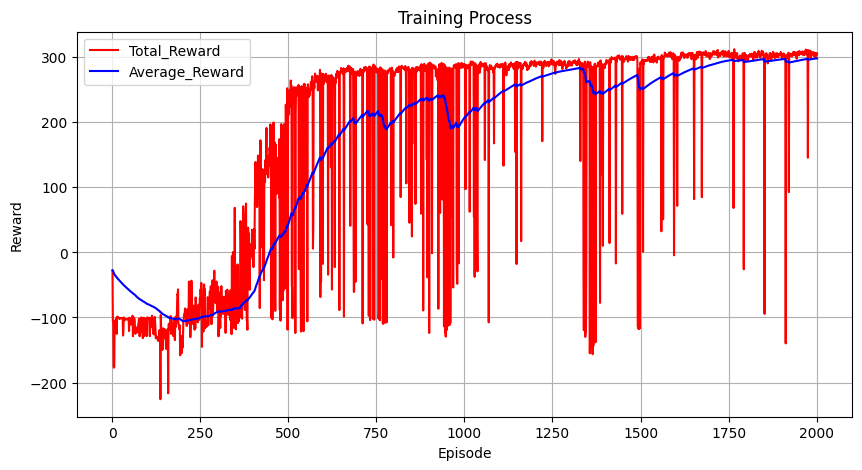

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(df[0], df[1], label='Total_Reward', color='red')
plt.plot(df[0], df[2], label='Average_Reward', color='blue')
plt.title('Training Process')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()